In [1]:
import gc
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import hamming_loss
from scipy.sparse.csr import csr_matrix

from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier

https://scikit-learn.org/stable/auto_examples/applications/plot_model_complexity_influence.html

In [2]:
def generate_dataset_classification():
    
    print("generating dataset...")
    
    data = sklearn.datasets.fetch_20newsgroups_vectorized(subset='all')

    X, y = csr_matrix(data.data), np.array(data.target)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=5)

    gc.collect()
    
    print('dataset generation complete...')
    
    return X_train, y_train, X_test, y_test

In [3]:
def atomic_predict(X_test, model):
    
    prediction_latencies = []
    
    for i in range(X_test.shape[0]):
        start = time.time()
        y_pred = model.predict(X_test[i].reshape(1, -1))
        
        prediction_latencies.append(time.time() - start)
        
    prediction_latencies = np.array(prediction_latencies)
    
    return np.percentile(prediction_latencies, 50)

In [4]:
def build_and_predict(model, 
                      X_train, y_train, X_test, y_test,
                      complexity_fn):
    
    model.fit(X_train, y_train)


    start = time.time()
    y_pred = model.predict(X_test)

    prediction_latency = time.time() - start

    complexity = complexity_fn(model)

    performance_score = hamming_loss(y_test, y_pred)
    
    return [complexity, prediction_latency, performance_score]

In [5]:
X_train, y_train, X_test, y_test = generate_dataset_classification()

generating dataset...
dataset generation complete...


In [6]:
X_train.shape, y_train.shape

((15076, 130107), (15076,))

In [7]:
X_test.shape, y_test.shape

((3770, 130107), (3770,))

In [8]:
sgd_classifier = SGDClassifier(penalty='elasticnet', alpha=0.001, tol=1e-1)

def _count_nonzero_coefficients(estimator):
    return np.count_nonzero(estimator.coef_)

In [10]:
build_and_predict(sgd_classifier, 
                  X_train, y_train, X_test, y_test,
                  _count_nonzero_coefficients)

[2370, 0.03802299499511719, 0.2872679045092838]

In [11]:
def plot_model_details(performance_details):
    
    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(right=0.75)

    plt.plot([row[0] for row in performance_details],
             [row[1] for row in performance_details])
    
    plt.plot([row[0] for row in performance_details],
             [row[2] for row in performance_details])

In [12]:
model_performance = {}

In [13]:
l1_ratios = [0.25, 0.5, 0.75, 0.9]

model_performance['sgd_classifier'] = []

for ratio in l1_ratios:
    sgd_classifier = SGDClassifier(penalty='elasticnet', 
                                   alpha=0.001, tol=1e-1, l1_ratio=ratio)
    
    performance_details = build_and_predict(sgd_classifier, 
                                            X_train, y_train, X_test, y_test,
                                            _count_nonzero_coefficients)
    
    model_performance['sgd_classifier'].append(performance_details)

In [14]:
performance_details = model_performance['sgd_classifier']

performance_details

[[795, 0.026153087615966797, 0.336604774535809],
 [214, 0.027158021926879883, 0.4750663129973475],
 [77, 0.04092597961425781, 0.5790450928381963],
 [43, 0.02581191062927246, 0.5936339522546419]]

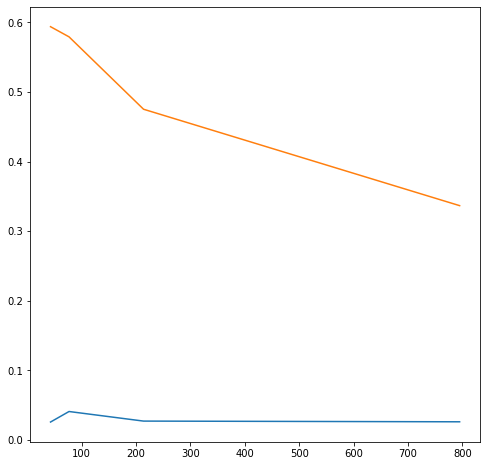

In [15]:
plot_model_details(performance_details)

In [ ]:
def _num_estimators(estimator):
    return estimator.n_estimators

In [ ]:
n_estimators = [3, 5, 8, 10, 12]

model_performance['gb_classifier'] = []

for n_estimator in n_estimators:
    gb_classifier = GradientBoostingClassifier(n_estimators=n_estimator)
    
    performance_details = build_and_predict(gb_classifier, 
                                            X_train, y_train, X_test, y_test,
                                            _num_estimators)
    
    model_performance['gb_classifier'].append(performance_details)
    
    print('Training complete', n_estimator)

In [ ]:
performance_details = model_performance['gb_classifier']

performance_details

In [ ]:
plot_model_details(performance_details)